참조 : https://github.com/hunkim/DeepLearningZeroToAll

# rnn & lstm 활용

## char-seq-rnn 
- 연속되는 문장에 대해 각 문자뒤에 나올 문자 예측 (RNN)
- h i h e l l  => i h e l l o 예측

In [38]:
import tensorflow as tf
import numpy as np
tf.reset_default_graph()
tf.set_random_seed(777)

idx2char = ['h','i','e','l','o']
# 다음에 나오는 단어를 학습 hihell => 각 char은 다음 단어들로 ihello가 나오게
x_data = [[0, 1, 0, 2, 3, 3]]   # hihell
x_one_hot = [[[1, 0, 0, 0, 0],   # h 0
              [0, 1, 0, 0, 0],   # i 1
              [1, 0, 0, 0, 0],   # h 0
              [0, 0, 1, 0, 0],   # e 2
              [0, 0, 0, 1, 0],   # l 3
              [0, 0, 0, 1, 0]]]  # l 3
y_data = [[1,0,2,3,3,4]] # ihello

num_classes = 5 # 단어 사전 수
input_dim = 5 # one-hot size
hidden_size = 5 # output 사이즈 (one-hot)
batch_size = 1 # 들어가는 문장 (여기선 hielo 하나 뿐)
sequence_length = 6 # |hihell| == 6
learning_rate = 0.01
#==============================
# RNN 모델
#==============================
# X one-hot [batch_size, 들어가게되는 input length(sequence data), 각 input에 대한 차원(one-hot)]
X = tf.placeholder(tf.float32, [None, sequence_length, input_dim])
# Y Label
Y = tf.placeholder(tf.int32, [None, sequence_length]) 
# cell을 생성, num_units는 출력 수
cell = tf.contrib.rnn.BasicRNNCell(num_units=hidden_size)
# lstn으로하려면 위의 BasicRNNCell을
# cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_size, state_id_tuple = True)로 바꿔주면 됨
# 여기서 num_units은 LSTM셀의 output size
# state_is_tuple은 True일 경우 c_state, m_state을 tuple 형식으로, false면 합쳐서 리턴
# cell state를 의미 ,,c_state = (sigmoid(f + self._forget_bias) * c_prev + sigmoid(i) * self._activation(j))
# hidden state를 의미,, m_state = sigmoid(o) * self._activation(c)
# 또는 rnn_cell.GRUCell(rnn_size)를 써서 GRU로도 사용 가능

# 모든 rnn cell들의 값들 0으로 set
initial_state = cell.zero_state(batch_size, tf.float32)
# output tensor와 최종상태인 state 리턴
# outpts = [1,seq_size,output_size]
# _staets = [1,output_size]
# cell 실행
outputs, _states = tf.nn.dynamic_rnn(cell, X, initial_state = initial_state, dtype = tf.float32)
print("X.shape : {}".format(X.shape))
print("Y.shape : {}".format(Y.shape))
print("outputs.shape : {}".format(outputs.shape))
print("_states.shape : {}".format(_states.shape))
print("====FC layer=====")

#==============================
# FC layer
#==============================

x_for_fc = tf.reshape(outputs, [-1, hidden_size])
print("x_for_fc.shape : {}".format(x_for_fc.shape))
# fc_w = tf.get_variable("fc_w", [hidden_size, num_classes])
# fc_b = tf.get_variable("fc_b", [num_classes])
# outputs = tf.matmul(X_for_fc, fc_w) + fc_b
outputs = tf.contrib.layers.fully_connected(inputs=x_for_fc, num_outputs = num_classes, activation_fn =None)
print(outputs.shape)
#==============================
# loss function
#==============================
# 전체 sequence에 대한 lossfunction 함수가 있음,  
# reshape out for sequence_loss
outputs = tf.reshape(outputs, [batch_size, sequence_length, num_classes])
print(outputs.shape)
# 예측된 전체 sequence_length(6)과 label값을 비교해 오차율로 학습
weights = tf.ones([batch_size, sequence_length])
sequence_loss = tf.contrib.seq2seq.sequence_loss(logits = outputs, targets = Y, weights = weights)

loss = tf.reduce_mean(sequence_loss)
train = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

prediction = tf.argmax(outputs, axis=2)

#==============================
# learning 
#==============================
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(200):
        l, _ = sess.run([loss, train], feed_dict = {X: x_one_hot, Y: y_data})
        result = sess.run(prediction, feed_dict = {X: x_one_hot})
        
        if i % 40 == 0:
            print(i, "loss : {} prediction : {} true Y : {}".format(l, result, y_data) )
            result_str = [idx2char[c] for c in np.squeeze(result)]
            print("\tPredction str : {}".format(''.join(result_str)))

X.shape : (?, 6, 5)
Y.shape : (?, 6)
outputs.shape : (1, 6, 5)
_states.shape : (1, 5)
====FC layer=====
x_for_fc.shape : (6, 5)
(6, 5)
(1, 6, 5)
0 loss : 1.7141227722167969 prediction : [[2 4 1 3 3 3]] true Y : [[1, 0, 2, 3, 3, 4]]
	Predction str : eoilll
40 loss : 0.6970529556274414 prediction : [[2 0 2 3 3 4]] true Y : [[1, 0, 2, 3, 3, 4]]
	Predction str : ehello
80 loss : 0.17991243302822113 prediction : [[1 0 2 3 3 4]] true Y : [[1, 0, 2, 3, 3, 4]]
	Predction str : ihello
120 loss : 0.06610546261072159 prediction : [[1 0 2 3 3 4]] true Y : [[1, 0, 2, 3, 3, 4]]
	Predction str : ihello
160 loss : 0.03839494287967682 prediction : [[1 0 2 3 3 4]] true Y : [[1, 0, 2, 3, 3, 4]]
	Predction str : ihello


##### 3차원 argmax
- argmax 하는 데이터의 shape이 (3, 4, 5)라 한다면
    - axis 0은 0번째를 축으로 하니 결과 값의 형태는 (4, 5)
    - axis 1은 1번째를 축으로 하니 결과 값의 형태는 (3, 5)
    - axis 2은 2번째를 축으로 하니 결과 값의 형태는 (3, 4)


In [70]:
# 3차원 argmax
# axis 0 
# axis 1
# axis 2
test1 = [
         [
             [7,2,3],[8,5,6]
         ],
         [
             [4,5,6],[0,3,9]
         ],
         [
             [4,0,6],[0,7,9]
         ],
         [
             [0,0,6],[0,-7,9]
         ]
       ]

sess = tf.Session()
print("===========")
print(sess.run(tf.argmax(test1, axis =0)))
print("===========")
print(sess.run(tf.argmax(test1, axis =1)))
print("===========")
print(sess.run(tf.argmax(test1, axis =2)))
print("===========")


[[0 1 1]
 [0 2 1]]
[[1 1 1]
 [0 0 1]
 [0 1 1]
 [0 0 1]]
[[0 0]
 [2 2]
 [2 2]
 [2 2]]


In [74]:
# 3차원 argmax
# axis 0 
# axis 1
# axis 2
test1 = [
         [
             [7,2,3],[8,5,6]
         ],
         [
             [4,5,6],[0,3,9]
         ],
         [
             [4,0,6],[0,7,9]
         ],
         [
             [0,0,6],[0,-7,9]
         ]
       ]

sess = tf.Session()
print("===========")
print(sess.run(tf.argmax(test1, axis =0)))
print("===========")
print(sess.run(tf.argmax(test1, axis =1)))
print("===========")
print(sess.run(tf.argmax(test1, axis =2)))
print("===========")

[[0 1 1]
 [0 0 1]]
[[1 1 1]
 [0 0 1]]
[[0 0]
 [2 2]]


## 연속되는 문장에 대해 문자 뒤 나오는 문자 예측 (LSTM)
- one-hot 인코딩을 tensorflow에서 제공하는 함수로 구현
- tf.contrib.rnn.BasicLSTMCell 함수 통해 LSTM모델 사용

In [107]:
import tensorflow as tf
import numpy as np
tf.reset_default_graph()
tf.set_random_seed(777)

sample = " if you want you"
idx2char = list(set(sample))
char2idx = {c: i for i,c in enumerate(idx2char)}
print("char2idx : {}".format(char2idx))
dic_size = len(char2idx) # one-hot size
hidden_size = len(char2idx) # output size
num_classes = len(char2idx) # final output size
batch_size = 1
sequence_length = len(sample) - 1 
learning_rate = 0.1

# 각 문자들을 숫자로
sample_idx = [char2idx[c] for c in sample]
# x data는 0 ~ n-1
x_data = [sample_idx[:-1]] 
# y data는 1 ~ n
y_data = [sample_idx[1:]]

# ================
# LSTM 모델 설계
# ================
X = tf.placeholder(tf.int32, [None, sequence_length])
Y = tf.placeholder(tf.int32, [None, sequence_length])

# one hot으로 바꿔줌
# tf.one_hot은 입력받는 shape의 뒤로 num_classes만큼의 차원이 추가로 생긴다고 보면 됨
# (1,15) == num_calsses(10) ==> (1,15,10)
x_one_hot = tf.one_hot(X, num_classes)
print("X.shape : {}".format(X.shape))
print("x_one_hot.shape : {}".format(x_one_hot.shape))
# LSTM cell 생성
# output_size가 hidden_size (단어 one-hot 차원 ) => 출력의 크기를 정해줌
#, cel state와 hidden state를 tuple 형식으로 반환하는 cell
cell = tf.contrib.rnn.BasicLSTMCell(num_units = hidden_size, state_is_tuple=True)
# 모든 cell state는 0으로 초기화 하고
initial_state = cell.zero_state(batch_size, tf.float32)
# cell 동작시킴, input으로 x_one_hot 넣고 수행
outputs, _states = tf.nn.dynamic_rnn(cell, x_one_hot, initial_state=initial_state, dtype=tf.float32)
print("outputs.shape : {}".format(outputs.shape))
# ================
# FC layer
# ================
print("=============== FC layer ===========")
X_for_fc = tf.reshape(outputs, [-1, hidden_size])
# fc_w = tf.get_variable("fc_w", [hidden_size, num_classes])
# fc_b = tf.get_variable("fc_b", [num_classes])
# outputs = tf.matmul(X_for_fc, fc_w) + fc_b

print("X_for_fc.shape : {}".format(X_for_fc.shape))
outputs = tf.contrib.layers.fully_connected(X_for_fc, num_classes, activation_fn=None)
print("outputs.shape : {}".format(outputs.shape))
# ================
# sequence loss 
# ================
outputs = tf.reshape(outputs, [batch_size, sequence_length, num_classes])
weights = tf.ones([batch_size, sequence_length])
# weights는 시퀀스의 각 엘리먼트들이 갖는 가중치(loss에서의)
# logits 부분은 one hot encoding
# targets부분은 one hot encoding X 
sequence_loss = tf.contrib.seq2seq.sequence_loss(logits=outputs, targets=Y, weights=weights)
loss = tf.reduce_mean(sequence_loss)
train = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

prediction = tf.argmax(outputs, axis=2)
print("prediction.shape : {}".format(prediction.shape))
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(200):
        l, _ = sess.run([loss, train], feed_dict={X: x_data, Y: y_data})
        result = sess.run(prediction, feed_dict={X: x_data})
        
        # squeeze는 차원 중 사이즈가 1인 것을 찾아 스칼라값으로 바꿔 해당 차원을 제거
        result_str = [idx2char[c] for c in np.squeeze(result)]
        
        if i % 40 == 0:
            print("result : {}".format(result))
            print("{} loss : {}, Prediction : {}".format(i,l, ''.join(result_str)))



char2idx : {'f': 0, 'y': 1, 'n': 2, 't': 3, 'w': 4, ' ': 5, 'a': 6, 'u': 7, 'i': 8, 'o': 9}
X.shape : (?, 15)
x_one_hot.shape : (?, 15, 10)
outputs.shape : (1, 15, 10)
=============== FC layer ===========
X_for_fc.shape : (15, 10)
outputs.shape : (15, 10)
prediction.shape : (1, 15)
result : [[9 5 5 5 9 7 5 5 7 7 5 5 5 9 7]]
0 loss : 2.297388792037964, Prediction : o   ou  uu   ou
result : [[8 0 5 1 9 7 5 4 6 2 3 5 1 9 7]]
40 loss : 0.0009547463268972933, Prediction : if you want you
result : [[8 0 5 1 9 7 5 4 6 2 3 5 1 9 7]]
80 loss : 0.000375739939045161, Prediction : if you want you
result : [[8 0 5 1 9 7 5 4 6 2 3 5 1 9 7]]
120 loss : 0.0002929738548118621, Prediction : if you want you
result : [[8 0 5 1 9 7 5 4 6 2 3 5 1 9 7]]
160 loss : 0.0002409441367490217, Prediction : if you want you


In [101]:
# 3차원 matrix reshape
test1 = [
         [
             [7,2,3],[8,5,6]
         ],
         [
             [4,5,6],[0,3,9]
         ],
         [
             [4,0,6],[0,7,9]
         ],
         [
             [0,0,6],[0,-7,9]
         ]
       ]
dd = np.array(test1)

print(dd.shape)
print(dd.reshape((3,2,4)))
print(dd.reshape((-1,4)))


(4, 2, 3)
[[[ 7  2  3  8]
  [ 5  6  4  5]]

 [[ 6  0  3  9]
  [ 4  0  6  0]]

 [[ 7  9  0  0]
  [ 6  0 -7  9]]]
[[ 7  2  3  8]
 [ 5  6  4  5]
 [ 6  0  3  9]
 [ 4  0  6  0]
 [ 7  9  0  0]
 [ 6  0 -7  9]]


## char-seq-softmax-only

In [129]:
import tensorflow as tf
import numpy as np
tf.reset_default_graph()
tf.set_random_seed(777)

sample = " if you want you"
idx2char = list(set(sample))
print("idx2char : {}".format(idx2char))
char2idx = {c:i for i,c in enumerate(idx2char)}
print("char2idx : {}".format(char2idx))

dic_size = len(idx2char) # 단어사전 수 
rnn_hidden_size = len(idx2char) # rnn output size
num_classes = len(idx2char) # fianl output size (fc,softmax)
batch_size = 1
sequence_length = len(sample) - 1
learning_rate = 0.05

sample_idx = [char2idx[c] for c in sample] # char to index
x_data = [sample_idx[:-1]] # x sequence 0 ~ n-1
y_dat = [sample_idx[1:]] # y sequence 1 ~ n

# build model
X = tf.placeholder(tf.int32, [None, sequence_length])
Y = tf.placeholder(tf.int32, [None, sequence_length])
print("X.shape : {}".format(X.shape))
print("Y.shape : {}".format(Y.shape))
# one-hot
X_one_hot = tf.one_hot(X, num_classes)
print("X_one_hot.shape : {}".format(X_one_hot.shape))
X_for_softmax = tf.reshape(X_one_hot, [-1, rnn_hidden_size])
print("X_for_softmax.shape : {}".format(X_for_softmax.shape))

# softmax layer
softmax_w = tf.get_variable("softmax_w", [rnn_hidden_size, num_classes])
softmax_b = tf.get_variable("softmax_b", [num_classes])
outputs = tf.matmul(X_for_softmax, softmax_w) + softmax_b
print("outputs.shape : {}".format(outputs.shape))

# revive the batches
outputs = tf.reshape(outputs, [batch_size, sequence_length, num_classes])
weights = tf.ones([batch_size, sequence_length])

# sequence loss
sequence_loss = tf.contrib.seq2seq.sequence_loss(logits = outputs, targets = Y, weights = weights)
loss = tf.reduce_mean(sequence_loss)
train = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

prediction = tf.argmax(outputs, axis = 2)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(5000):
        l, _  = sess.run([loss, train], feed_dict = {X:x_data, Y:y_data})
        result = sess.run(prediction, feed_dict = {X:x_data})
        
        if i % 1000 == 0:
            result_str = [idx2char[c] for c in np.squeeze(result)]
            print("{} loss : {}, prediction : {}".format(i, l, ''.join(result_str)))


idx2char : ['f', 'y', 'n', 't', 'w', ' ', 'a', 'u', 'i', 'o']
char2idx : {'f': 0, 'y': 1, 'n': 2, 't': 3, 'w': 4, ' ': 5, 'a': 6, 'u': 7, 'i': 8, 'o': 9}
X.shape : (?, 15)
Y.shape : (?, 15)
X_one_hot.shape : (?, 15, 10)
X_for_softmax.shape : (?, 10)
outputs.shape : (?, 10)
0 loss : 2.2934999465942383, prediction : yu yauoytttoyau
1000 loss : 0.27862435579299927, prediction : yf you yant you
2000 loss : 0.2776661515235901, prediction : yf you yant you
3000 loss : 0.27743953466415405, prediction : yf you yant you
4000 loss : 0.27735191583633423, prediction : yf you yant you


## long_char_seq_rnn
- rnn의 cell을 한 층 더 쌓아줌
- 마지막에 softmax로 분류
![image](https://user-images.githubusercontent.com/28910538/55369062-ebd5ec00-552f-11e9-8da5-7e8619ad716c.png)


In [4]:
import tensorflow as tf
import numpy as np
tf.reset_default_graph()
tf.set_random_seed(777)

sentence = ("if you want to build a ship, don't drum up people together to "
            "collect wood and don't assign them tasks and work, but rather "
            "teach them to long for the endless immensity of the sea.")

char_set = list(set(sentence))
print("char_set : {}".format(char_set))
char_dic = {w:i for i,w in enumerate(char_set)}
print("char_dic : {}".format(char_dic))

data_dim = len(char_set)
hidden_size = len(char_set)
num_classes = len(char_set)
sequence_length = 10
learning_rate = 0.1

x_data = []
y_data = []
# sentence 앞에서부터 10개씩 쭈욱 땡기면서 char2idx 해서 x,y_data에 넣어줌
for i in range(0, len(sentence) - sequence_length):
    x_str = sentence[i: i + sequence_length]
    y_str = sentence[i+1: i+ sequence_length + 1]
    if i % 20 == 0:
        print(i, x_str, '->', y_str)
    x = [char_dic[c] for c in x_str]
    y = [char_dic[c] for c in y_str]
    
    x_data.append(x)
    y_data.append(y)
    
batch_size = len(x_data)
print("batch_size : {}".format(batch_size))
# bulid model
X = tf.placeholder(tf.int32, [None, sequence_length])
Y = tf.placeholder(tf.int32, [None, sequence_length])

# one-hot
X_one_hot = tf.one_hot(X, num_classes)
print("X_one_hot.shape : {}".format(X_one_hot.shape))

def lstm_cell():
    cell = tf.contrib.rnn.BasicLSTMCell(num_units = hidden_size, state_is_tuple = True )
    return cell
    
# rnn을 한층 더 쌓으려면 MultiRNNCell에 생성한 cell을 넣어준다
multi_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell() for _ in range(2)], state_is_tuple = True)

outputs, _states = tf.nn.dynamic_rnn(multi_cells, X_one_hot, dtype = tf.float32)
print("outputs.shape : {}".format(outputs.shape))

# softmax 
outputs = tf.reshape(outputs, [batch_size, sequence_length, num_classes])
print("outputs.shape : {}".format(outputs.shape))

X_for_softmax = tf.reshape(outputs, [-1, hidden_size])
print("X_for_softmax.shape : {}".format(X_for_softmax.shape))

softmax_w = tf.get_variable("softmax_w", [hidden_size, num_classes])
softmax_b = tf.get_variable("softmax_b", [num_classes])
# softmax output
outputs = tf.matmul(X_for_softmax, softmax_w) + softmax_b
# rnn output
outputs = tf.reshape(outputs, [batch_size, sequence_length, num_classes])

#sequecne_loss
weights = tf.ones([batch_size, sequence_length])

sequence_loss = tf.contrib.seq2seq.sequence_loss(logits=outputs, targets=Y, weights =weights)
mean_loss = tf.reduce_mean(sequence_loss)
train_op = tf.train.AdamOptimizer(learning_rate =learning_rate).minimize(mean_loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(500):
    _, l, results = sess.run([train_op, mean_loss, outputs], feed_dict = {X:x_data, Y:y_data})
    
    for j, result in enumerate(results):
        index = np.argmax(result, axis = 1)
        if i % 100 == 0 and j % 17 == 0:
            print (i,j, ''.join([char_set[t] for t in index]), l)
        
results = sess.run(outputs, feed_dict = {X:x_data})
for j, result in enumerate(results):
    index = np.argmax(result, axis=1)
    if j is 0:
        print(''.join([char_set[t] for t in index]), end ='')
    else:
        print(char_set[index[-1]], end='')
        

char_set : ['o', ',', 's', 'k', 'c', 'w', 'a', 'i', 'f', '.', 'p', 'n', 'u', 'r', 'g', 'l', 'y', 'h', "'", 'd', 'm', ' ', 'e', 't', 'b']
char_dic : {'o': 0, ',': 1, 's': 2, 'k': 3, 'c': 4, 'w': 5, 'a': 6, 'i': 7, 'f': 8, '.': 9, 'p': 10, 'n': 11, 'u': 12, 'r': 13, 'g': 14, 'l': 15, 'y': 16, 'h': 17, "'": 18, 'd': 19, 'm': 20, ' ': 21, 'e': 22, 't': 23, 'b': 24}
0 if you wan -> f you want
20  a ship, d -> a ship, do
40 up people  -> p people t
60 o collect  ->  collect w
80 on't assig -> n't assign
100 ks and wor -> s and work
120 her teach  -> er teach t
140 ng for the -> g for the 
160 mmensity o -> mensity of
batch_size : 170
X_one_hot.shape : (?, 10, 25)
outputs.shape : (?, 10, 25)
outputs.shape : (170, 10, 25)
X_for_softmax.shape : (1700, 25)
0 0 rrrrrrrrrr 3.2312617
0 17 rrrrrrrrrr 3.2312617
0 34 rrrrrrrrrr 3.2312617
0 51 rrrrrrrrrr 3.2312617
0 68 rrrrrrrrrr 3.2312617
0 85 rrrrrrrrrr 3.2312617
0 102 rrrrrrrrrr 3.2312617
0 119 rrrrrrrrrr 3.2312617
0 136 rrrrrrrrrr 3.2312617
0 153 r

## rnn-stock-prediction
- 주식 시장 일정 sequence로 open, hight, low, volume, close로 일정 sequence 지나고 나서의 close 가격을 예측

trainX.shape : (505, 7, 5), trainY.shape : (505, 1)
output.shape : (?, 7, 10)
[step : 0] loss : 166.21408081054688
[step : 100] loss : 1.2327989339828491
[step : 200] loss : 1.041332721710205
[step : 300] loss : 0.8704195022583008
[step : 400] loss : 0.768466055393219
RMSE: 0.05135541409254074


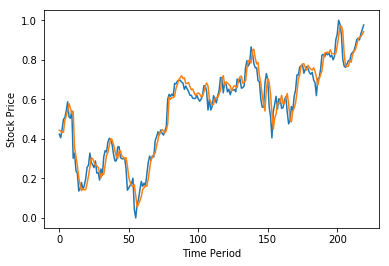

In [60]:
import tensorflow as tf
import numpy as np
import matplotlib
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

tf.reset_default_graph()
tf.set_random_seed(777)

scaler = MinMaxScaler()

seq_length = 7
data_dim = 5
hidden_dim = 10
output_dim = 1
learning_rate = 0.01
iterations = 500

xy = np.loadtxt('../data/movie/data-02-stock_daily.csv', delimiter=',')
# 뒤집어주고
xy = xy[::-1]

# train/test split
train_size = int(len(xy)*0.7)
train_set = xy[0:train_size]
test_set = xy[train_size - seq_length:]

train_set = scaler.fit_transform(train_set)
test_set = scaler.fit_transform(test_set)

# X : 일정 seq_length로 주식시장에서의 모든 가격 파라미터(5차원) 
# Y : 일정 seq_length가 지났을때의 주식 close 가격
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        _x = time_series[i:i + seq_length, :]
        _y = time_series[i + seq_length, [-1]] # next close price
        
        #if i % 500 == 0:
        #    print(_x, "->", _y)
        dataX.append(_x)
        dataY.append(_y)
    
    return np.array(dataX), np.array(dataY)

trainX, trainY = build_dataset(train_set, seq_length)
testX, testY = build_dataset(test_set, seq_length)
# (505, 7, 5)
print("trainX.shape : {}, trainY.shape : {}".format(trainX.shape, trainY.shape))
X = tf.placeholder(tf.float32, [None, seq_length, data_dim])
Y = tf.placeholder(tf.float32, [None, 1])

cell = tf.contrib.rnn.BasicLSTMCell(num_units = hidden_dim, state_is_tuple = True, activation = tf.tanh)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype = tf.float32)
# (?, 7, 10)
print("output.shape : {}".format(outputs.shape))

Y_pred = tf.contrib.layers.fully_connected(outputs[:,-1], output_dim, activation_fn=None)

# loss
loss = tf.reduce_sum(tf.square(Y_pred -Y))
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
# 평균제곱오차
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={X: trainX, Y: trainY})
        if i % 100 == 0:
            print("[step : {}] loss : {}".format(i, step_loss))
    
    test_predict = sess.run(Y_pred, feed_dict={X: testX})
    rmse_val = sess.run(rmse, feed_dict = {targets : testY, predictions : test_predict})
    print("RMSE: {}".format(rmse_val))

    
    plt.plot(testY)
    plt.plot(test_predict)
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()

In [66]:
a = np.array([[[1,2,3],[4,5,6]],
     [[7,8,9],[1,2,3]],
     [[4,5,6],[6,4,5]]])
print(a.shape)
print("================")
print(a)
print("================")
print(a[1:3,0])
print("================")
print(a[-1].shape)


(3, 2, 3)
[[[1 2 3]
  [4 5 6]]

 [[7 8 9]
  [1 2 3]]

 [[4 5 6]
  [6 4 5]]]
[[7 8 9]
 [4 5 6]]
(2, 3)


In [29]:
display(train_set[1:3,:])
display(train_set[3,[-1]])

array([[  561.202549,   566.43259 ,   558.672539, 41200.      ,
          559.992565],
       [  566.892592,   567.002574,   556.932537, 10800.      ,
          556.972503]])

array([567.162558])